In [16]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
from random import randint
from IPython.core.debugger import set_trace



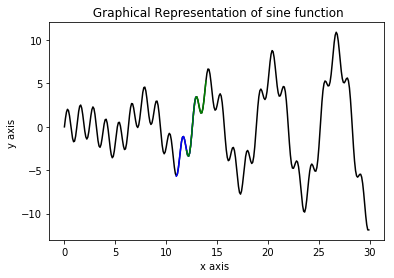

In [17]:
def select_sample(x,y,range_start,range_stop):
    random = randint(range_start,range_stop-2) #generate random no. 0-28
    #print("Random:", random) #print random no.
    start = random*10 #get array start index
    stop = (random+2)*10 #get array end index
    x_sample = x[start:stop] #x[]
    y_sample = y[start:stop]
    
    return x_sample,y_sample

start = 0
stop = 30
batch_size = 50       #batch_size
train_size = 1000
x = np.arange(start, stop, 0.1)
y = ((x*np.sin(x))/3)+(2*np.sin(5*x)) # Time series

#x1,y1 = select_sample(x,y,start,stop)
x_train = []
y_train = []
xt = []
yt = []
for sample in range(train_size):
    xs , ys= select_sample(x,y,start,stop)
    x_train.append(xs)
    y_train.append(ys)
for sample in range(train_size):
    xs2, ys2 = select_sample(x,y,start,stop)
    xt.append(xs2)
    yt.append(ys2)
    
plt.plot(x, y,color="black") # plot grah
plt.plot(x_train[0],y_train[0],color="blue")
plt.plot(xt[0],yt[0],color="green")
plt.title(" Graphical Representation of sine function")
plt.xlabel("x axis ")
plt.ylabel("y axis ")
plt.show()

Original Data:  [-5.6661411  -5.41336372 -4.69869886 -3.69076962 -2.62111889 -1.72752056
 -1.1958586  -1.11480453 -1.45438932 -2.07371464 -2.75591291 -3.26179329
 -3.38903462 -3.02242759 -2.16285865 -0.92793235  0.4759282   1.80308053
  2.82782733  3.39867043] 
Predicted Data:  [[-0.13228473]
 [ 0.27758902]
 [-0.12964389]
 [ 0.2515765 ]
 [-0.11389297]
 [ 0.03474525]
 [ 0.147995  ]
 [ 0.22280857]
 [ 0.2666816 ]
 [-0.10009887]
 [-0.0865427 ]
 [ 0.17411983]
 [-0.07520793]
 [ 0.13923615]
 [ 0.64952815]
 [-0.00391336]
 [ 0.08574726]
 [ 0.31322742]
 [ 0.0022156 ]
 [ 0.20101035]]


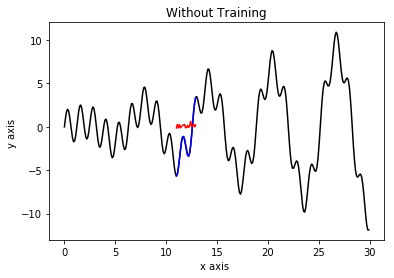

Iteration:  0 MSE:  17.167085647583008


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [18]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, batch_size, seq_len):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity="relu")
        self.hn = torch.randn(1, batch_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Set initial hidden 
        #h0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
        out = []
        # Forward propagate
        for i in range(seq_len):
            _,self.hn = self.rnn(x[:,i,:].unsqueeze(-1), self.hn)
            out.append(self.fc(self.hn))
        #out, hn = self.rnn(x, h0)
        
        # Decode the hidden state of the last time step
        #out = self.fc(out)
        out = torch.cat(out).view(self.batch_size, self.seq_len, self.output_size)
        return out

# Parameters
seq_len = 20
num_layers = 1 
input_size = 1
hidden_size = 100
output_size = 1
iteration = 0
n_iterations = 10   
learning_rate = 0.001   #lr

model = RNN(input_size, hidden_size, output_size, num_layers, batch_size, seq_len)

#Function to convert batches from np.array to torch.Tensor
def conversion(x_array, y_array, seq_len, batch= 1, input_size = 1, output_size = 1):
    
    x_tensor = torch.Tensor(x_array)
    x_tensor = x_tensor.view(seq_len, batch, input_size)

    y_tensor = torch.Tensor(y_array)
    y_tensor = y_tensor.view(seq_len, batch, input_size)
    
    return x_tensor, y_tensor

#Shortcut variables to easily plot graphs
x1 = np.copy(x_train[0])
y1 = np.copy(y_train[0])
x2 = np.copy(xt)
y2 = np.copy(yt)

#Convert training batches from np to Tensor
#for batch_index in range(batch_size):
    #x_batches[batch_index], y_batches[batch_index] = conversion(x_batches[batch_index], y_batches[batch_index], seq_len)
x_train, y_train = map(torch.Tensor,(x_train,y_train))
x_train.view(train_size,seq_len,1,1)
y_train.view(train_size,seq_len,1,1)

xt, yt = map(torch.Tensor,(xt,yt))
xt.view(train_size,seq_len,1,1)
yt.view(train_size,seq_len,1,1)

#for batch_index in range(train_size):
    #x_train[batch_index], y_train[batch_index] = conversion(x_train[batch_index], y_train[batch_index], seq_len)
    
#Convert Test Set from np to Tensor
#xt, _ = conversion(xt, yt, seq_len)

# Without Training
with torch.no_grad():
    y_no = model(x_train[0:batch_size].unsqueeze(-1))
    y_no = y_no[0].numpy()
    y_no = y_no.reshape(seq_len,1)
    print("Original Data: ", y1, "\nPredicted Data: ", y_no)

plt.plot(x, y,color="black") # plot grah
plt.plot(x1,y1,color="blue") #original data
plt.plot(x1,y_no,color="red") #predicted data
plt.title("Without Training")
plt.xlabel("x axis ")
plt.ylabel("y axis ")
plt.show()

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Calculate no. of Batches
num_batch = train_size/batch_size #train size should be divisible by batch size (integer)

# Train the model
def training(x_train, y_train, n_iterations):
    for iteration in range(n_iterations):
        batch_ind = np.random.permutation(train_size) # 0 to 999 in a random order e.g. [32, 502, 479 ...]
        for batch in range(int(num_batch)):
            current_ind = batch_ind[batch*batch_size:(batch+1)*batch_size]
            #current_ind = int(current_ind)
            # Forward pass
            optimiser.zero_grad()
            y_pred = model(x_train[current_ind].unsqueeze(-1))
            det_y_pred = y_pred.detach()
            loss = criterion(det_y_pred,y_train[current_ind].unsqueeze(-1))
            if batch % num_batch == 0 and iteration % 100 == 0:
                print("Iteration: ", iteration, "MSE: ", loss.item())
            loss.backward()
            optimiser.step()
            
model.train()
training(x_train,y_train,n_iterations)

#for i in range(train_size):
    #training(x_train[i], y_train[i], n_iterations)
    #if i%10 == 0:
        #print("Done with Batch",i)

# After Training
with torch.no_grad():
    y_aft = model(x_train[0:batch_size].unsqueeze(-1))
    y_aft = y_aft[0].numpy()
    print(y_aft.shape)
    y_aft = y_aft.reshape(seq_len, 1)
    print("Original Data: ", y1, "\nPredicted Data: ", y_aft)

plt.plot(x, y,color="black") # plot grah
plt.plot(x1,y1,color="blue") #original data
plt.plot(x1,y_aft,color="red") #predicted data
plt.title("After Training")
plt.xlabel("x axis ")
plt.ylabel("y axis ")
plt.show()

#Test the Model
model.eval()
with torch.no_grad():
    y_test_pred = model(xt[0:batch_size].unsqueeze(-1))
    y_test_pred = y_test_pred[0].numpy()
    print(y_test_pred.shape)
    y_test_pred = y_test_pred.reshape(seq_len,1)
    print("Original Data: ", y2, "\nPredicted Data: ", y_test_pred)

plt.plot(x, y,color="black") # plot grah
plt.plot(x2,y2,color="green") #original data
plt.plot(x2,y_test_pred[0],color="red") #predicted data
plt.title("Testing the Model")
plt.xlabel("x axis ")
plt.ylabel("y axis ")
plt.show()